In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [2]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [3]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [4]:


def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1, prob=True):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    if prob:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax

In [5]:
dfhw=pd.read_csv("https://dl.dropboxusercontent.com/u/75194/stats/data/01_heights_weights_genders.csv")
print dfhw.shape
dfhw.head()

(10000, 3)


,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [6]:
df=dfhw.sample(500, replace=False)
np.sum(df.Gender=="Male")

243

In [7]:
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
mask[:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

C:\Users\Erica\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


using mask
BEST {'C': 0.001} 0.906666666667 [mean: 0.90667, std: 0.04026, params: {'C': 0.001}, mean: 0.89000, std: 0.03333, params: {'C': 0.01}, mean: 0.89000, std: 0.03333, params: {'C': 0.1}, mean: 0.89000, std: 0.03333, params: {'C': 1}, mean: 0.89000, std: 0.03333, params: {'C': 10}, mean: 0.89000, std: 0.03333, params: {'C': 100}, mean: 0.89000, std: 0.03333, params: {'C': 1000}, mean: 0.89000, std: 0.03333, params: {'C': 10000}]
############# based on standard predict ################
Accuracy on training data: 0.90
Accuracy on test data:     0.90
[[91  8]
 [12 89]]
########################################################


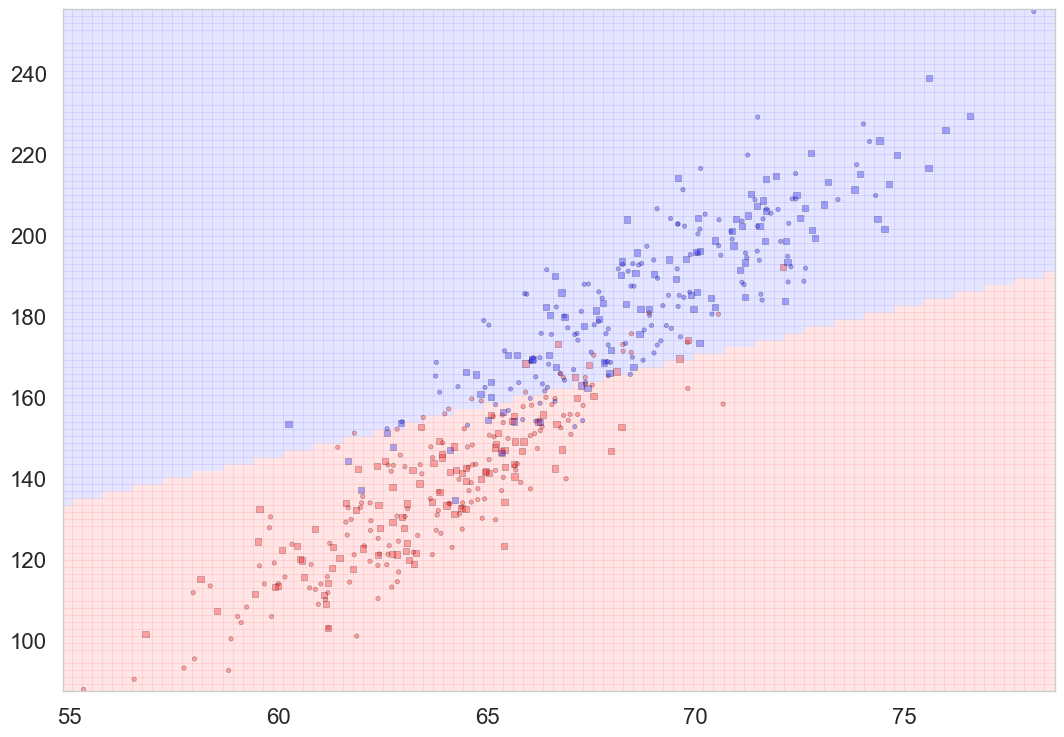

In [8]:
from sklearn.linear_model import LogisticRegression
clflog = LogisticRegression()
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clflog, Xtrain, ytrain, Xtest, ytest=do_classify(clflog, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog);

In [9]:
clflog.predict(Xtest)

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1])

In [10]:
clflog.predict_proba(Xtest)

array([[ 0.50694797,  0.49305203],
       [ 0.69025567,  0.30974433],
       [ 0.41007383,  0.58992617],
       [ 0.08454932,  0.91545068],
       [ 0.70570087,  0.29429913],
       [ 0.74293632,  0.25706368],
       [ 0.37550212,  0.62449788],
       [ 0.11867962,  0.88132038],
       [ 0.83723538,  0.16276462],
       [ 0.66690609,  0.33309391],
       [ 0.11083758,  0.88916242],
       [ 0.56931893,  0.43068107],
       [ 0.67679419,  0.32320581],
       [ 0.72411634,  0.27588366],
       [ 0.05106651,  0.94893349],
       [ 0.47032247,  0.52967753],
       [ 0.22280127,  0.77719873],
       [ 0.44840793,  0.55159207],
       [ 0.32328494,  0.67671506],
       [ 0.70192348,  0.29807652],
       [ 0.81307929,  0.18692071],
       [ 0.00954861,  0.99045139],
       [ 0.70499232,  0.29500768],
       [ 0.63269501,  0.36730499],
       [ 0.47091501,  0.52908499],
       [ 0.06619771,  0.93380229],
       [ 0.10506811,  0.89493189],
       [ 0.2808836 ,  0.7191164 ],
       [ 0.82896828,

In [11]:
clflog.predict_proba(Xtest)[:,1]

array([ 0.49305203,  0.30974433,  0.58992617,  0.91545068,  0.29429913,
        0.25706368,  0.62449788,  0.88132038,  0.16276462,  0.33309391,
        0.88916242,  0.43068107,  0.32320581,  0.27588366,  0.94893349,
        0.52967753,  0.77719873,  0.55159207,  0.67671506,  0.29807652,
        0.18692071,  0.99045139,  0.29500768,  0.36730499,  0.52908499,
        0.93380229,  0.89493189,  0.7191164 ,  0.17103172,  0.17097138,
        0.09615111,  0.12450096,  0.1859176 ,  0.22741731,  0.96636942,
        0.13199137,  0.22779552,  0.6730213 ,  0.92838934,  0.96047201,
        0.30397908,  0.95263715,  0.34779978,  0.45743102,  0.94701687,
        0.91484742,  0.08477599,  0.09210894,  0.16088644,  0.89837268,
        0.93637307,  0.64229417,  0.97802439,  0.09953202,  0.06621843,
        0.72506536,  0.03749386,  0.41096521,  0.81674116,  0.48169547,
        0.22617736,  0.10856253,  0.8999259 ,  0.08355641,  0.91297654,
        0.92145522,  0.43552231,  0.14979654,  0.12590564,  0.07

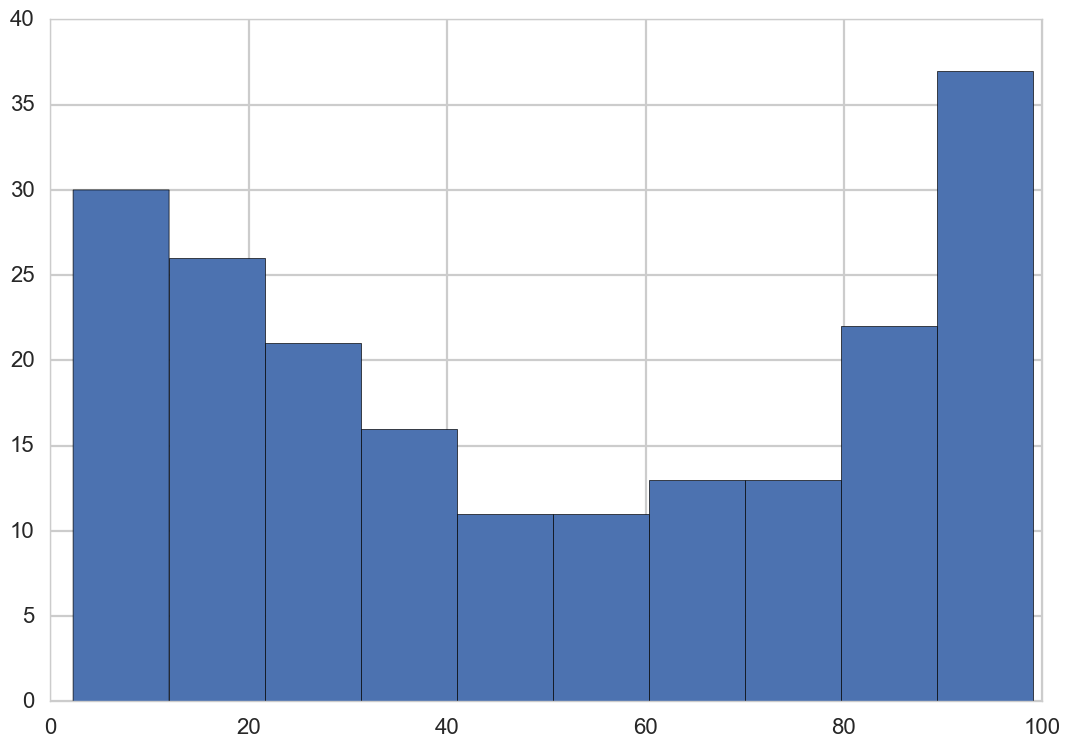

In [12]:
plt.hist(clflog.predict_proba(Xtest)[:,1]*100);

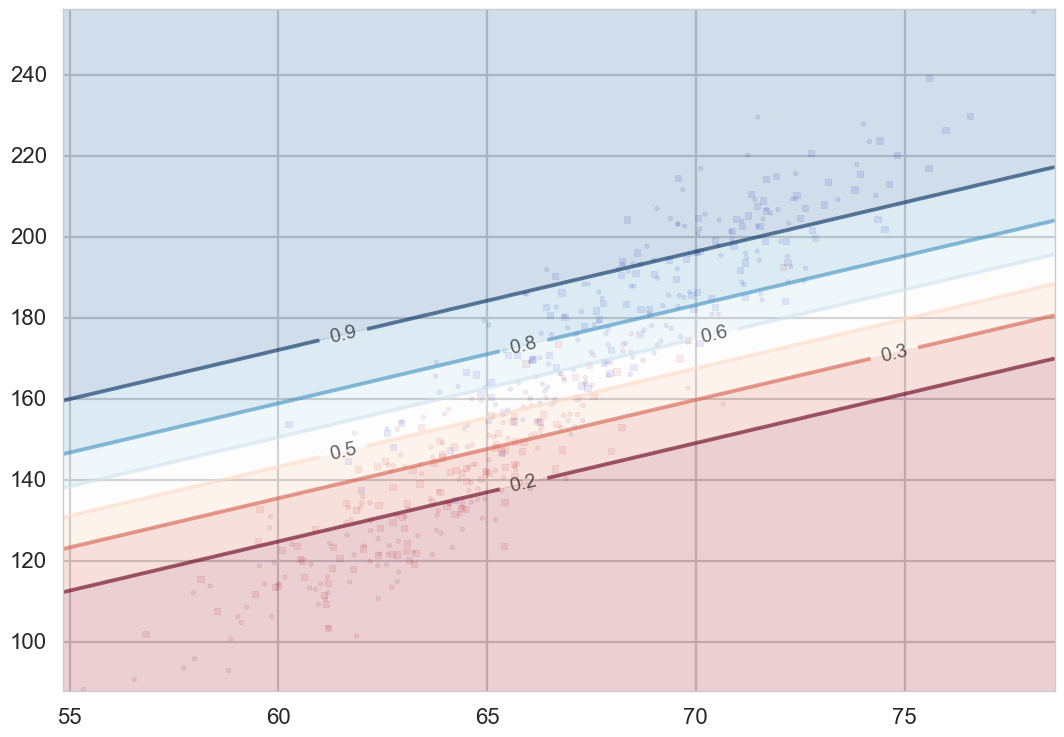

In [13]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog, mesh=False, alpha=0.001);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clflog);

In [14]:
clflog.score(Xtest, ytest)

0.90000000000000002

C:\Users\Erica\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


using mask
BEST {'C': 0.001} 0.906666666667 [mean: 0.90667, std: 0.04509, params: {'C': 0.001}, mean: 0.90667, std: 0.04085, params: {'C': 0.01}, mean: 0.90000, std: 0.04361, params: {'C': 0.1}, mean: 0.89667, std: 0.03734, params: {'C': 1}, mean: 0.89667, std: 0.03734, params: {'C': 10}, mean: 0.90333, std: 0.04286, params: {'C': 100}, mean: 0.90667, std: 0.04069, params: {'C': 1000}]
############# based on standard predict ################
Accuracy on training data: 0.91
Accuracy on test data:     0.89
[[91  8]
 [15 86]]
########################################################


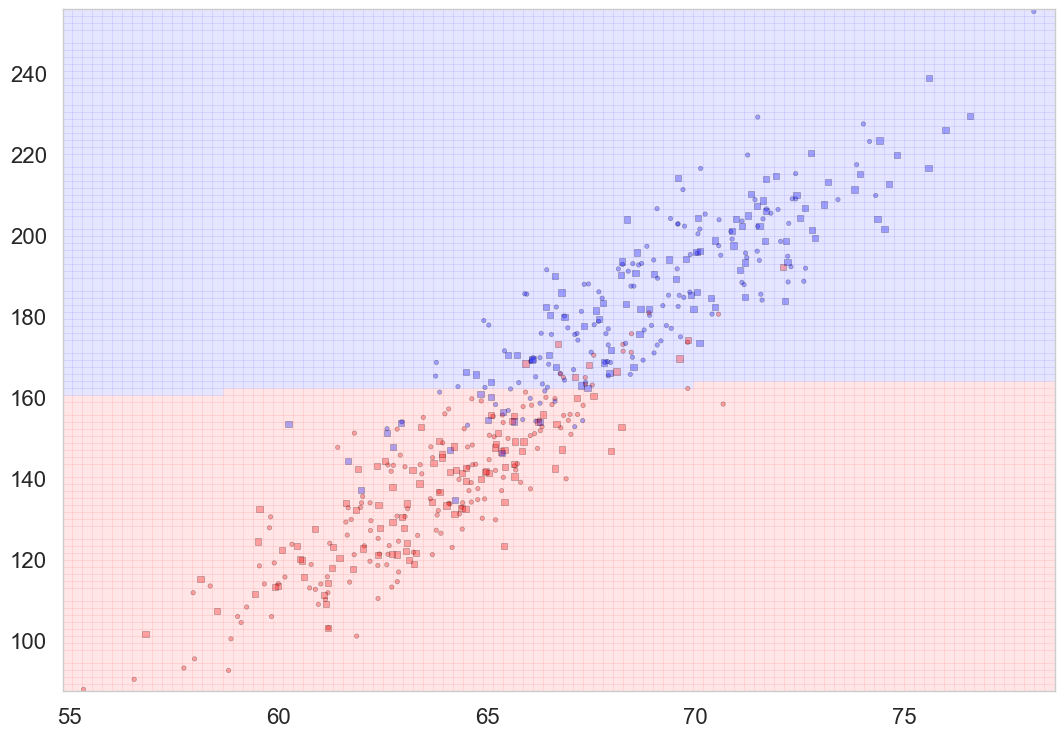

In [15]:
from sklearn.svm import SVC
clfsvm = SVC(kernel="linear")
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clfsvm, Xtrain, ytrain, Xtest, ytest=do_classify(clfsvm, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);

In [16]:
clfsvm.decision_function(Xtest)

array([-0.99327644, -1.62708651,  0.67055085,  2.84536182, -1.76167198,
       -1.50275042,  0.58478886,  2.42397425, -3.64694975, -1.45146159,
        3.63146988, -0.16249308, -1.55065824, -1.49999641,  4.63671647,
        0.4062914 ,  1.98975451,  0.32485485,  0.42216107, -1.39971625,
       -2.9064874 ,  7.62744149, -1.2627945 , -0.78961658,  0.44168791,
        4.99805478,  3.53273071,  0.88982735, -2.75774587, -1.94544502,
       -4.13655946, -3.35499356, -2.79114092, -2.02642055,  5.23879763,
       -3.20636473, -1.47384705,  0.67475785,  4.43419655,  4.21730748,
       -1.25714236,  5.26562137, -1.87817731, -0.59440288,  4.23375763,
        4.18085662, -4.09696666, -3.85818373, -3.35154875,  3.37564558,
        4.37212801,  0.9795074 ,  5.23004974, -4.09935001, -4.75602769,
        2.01517352, -5.21994483, -1.35987257,  1.8228998 , -0.85933483,
       -2.26730922, -3.80309679,  3.41364241, -3.74483111,  3.17473603,
        3.39080659, -0.71635285, -2.68415576, -2.89346487, -3.94

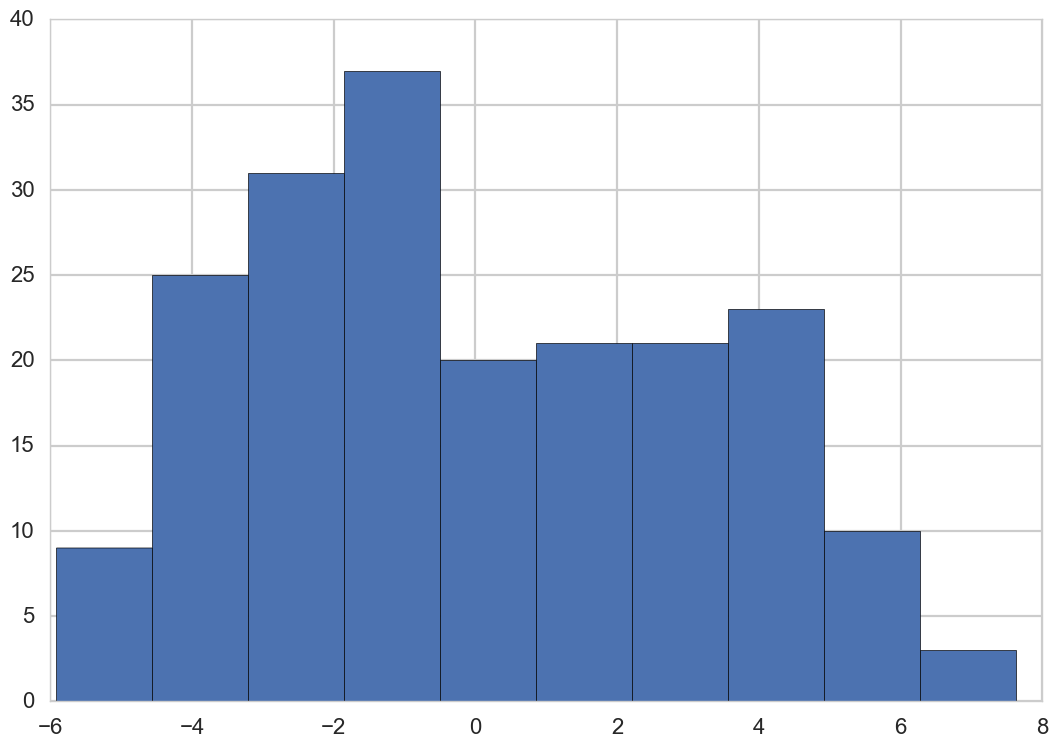

In [17]:
plt.hist(clfsvm.decision_function(Xtest));

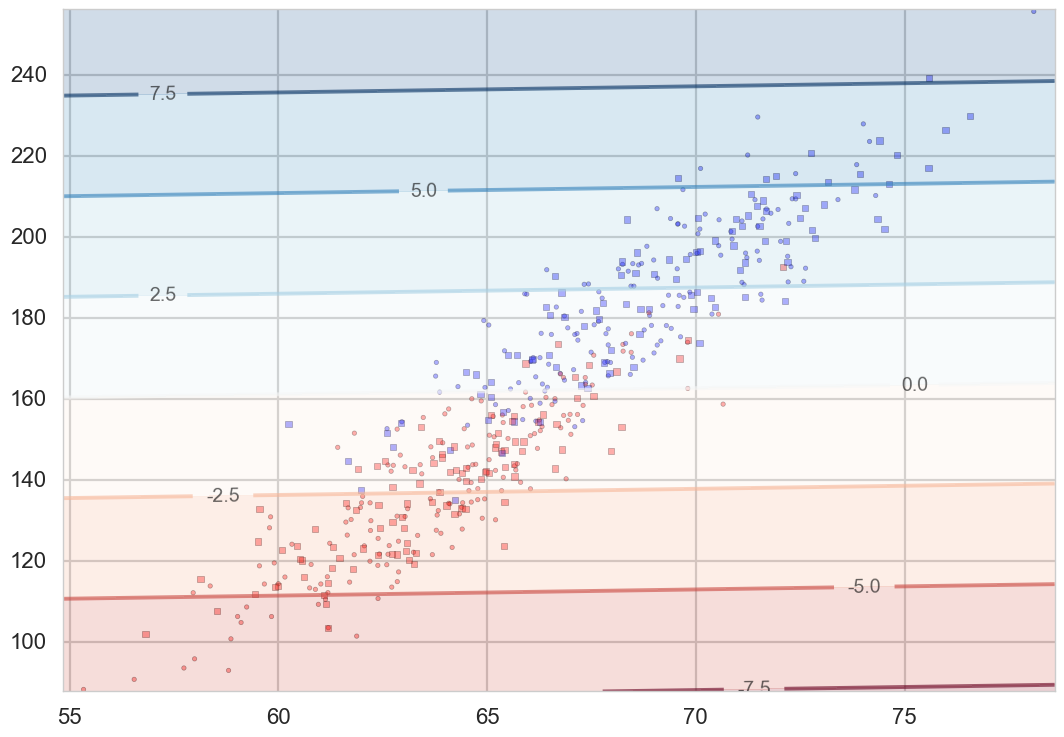

In [18]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, mesh=False);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, prob=False);

In [19]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    return ax.contour(X, Y, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

C:\Users\Erica\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\Erica\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\Erica\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning

(125, 225)

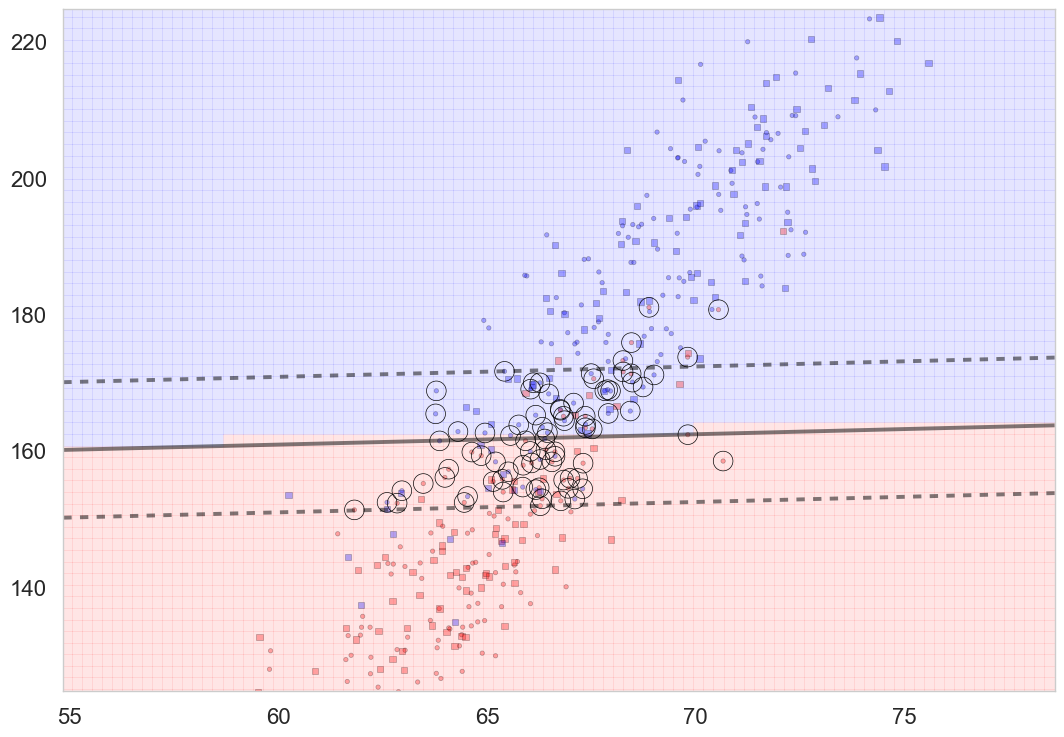

In [25]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);
plot_svc_decision_function(clfsvm, ax)
ax.scatter(clfsvm.support_vectors_[:, 0], clfsvm.support_vectors_[:, 1],s=200, facecolors='none')
plt.ylim([125,225])

In [26]:
confusion_matrix(ytest, clflog.predict(Xtest))

array([[91,  8],
       [12, 89]])

In [27]:
from sklearn.metrics import classification_report
print classification_report(ytest, clflog.predict(Xtest))

             precision    recall  f1-score   support

          0       0.88      0.92      0.90        99
          1       0.92      0.88      0.90       101

avg / total       0.90      0.90      0.90       200



In [28]:
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [29]:
confusion_matrix(ytest, t_repredict(clflog, 0.1, Xtest))

array([[ 25,  74],
       [  0, 101]])

In [30]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in xrange(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

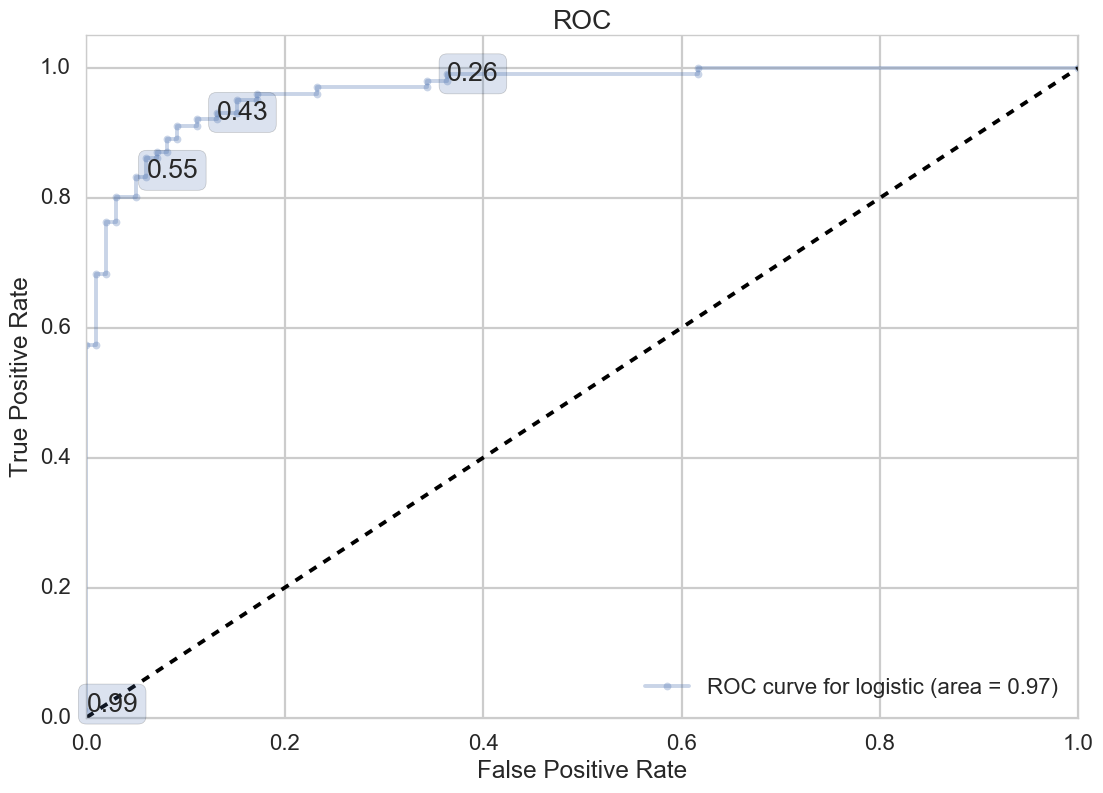

In [31]:
from sklearn.metrics import roc_curve, auc
ax=make_roc("logistic", clflog, ytest, Xtest, labe=10)

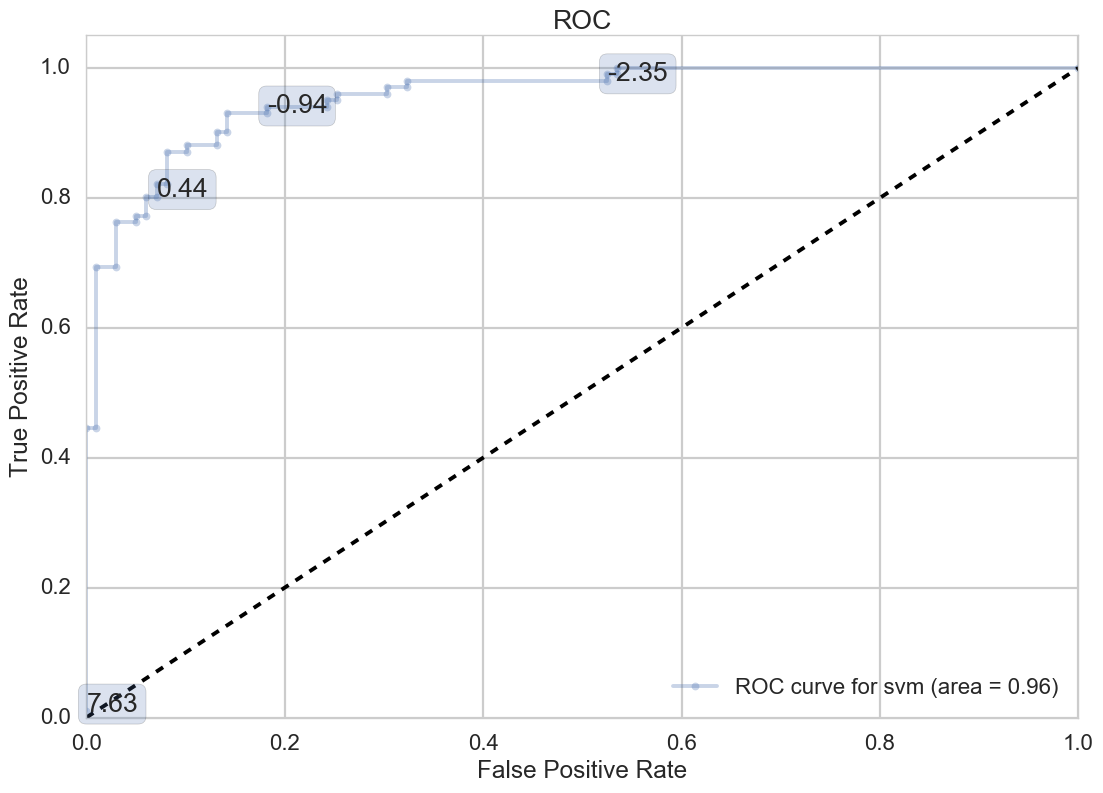

In [32]:
make_roc("svm", clfsvm, ytest, Xtest, labe=10, proba=False)